<a href="https://colab.research.google.com/github/farelreza/Big-Data-Analytics-PySpark-WInd-Turbine-Datasets/blob/main/final_big_data_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark py4j

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 199 kB 67.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=d832d6fe8e081d0a0a5534d58731fc9afebf3f87c8a235a9bc74064b806480e6
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test_pyspark").getOrCreate()
spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/T1.csv", header=True, inferSchema=True)

In [ ]:
df.cache()
df = df.toDF(*[c.lower() for c in df.columns])

In [ ]:
df.printSchema()

root
 |-- date/time: string (nullable = true)
 |-- lv activepower (kw): double (nullable = true)
 |-- wind speed (m/s): double (nullable = true)
 |-- theoretical_power_curve (kwh): double (nullable = true)
 |-- wind direction (°): double (nullable = true)



In [ ]:
df.count()

50530

In [ ]:
from pyspark.sql.functions import substring
df = df.withColumn("month", substring("date/time", 4,2))
df = df.withColumn("hour", substring("date/time", 12,2))

In [ ]:
from pyspark.sql.types import IntegerType
df = df.withColumn('month', df.month.cast(IntegerType()))
df = df.withColumn('hour', df.hour.cast(IntegerType()))

print(df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

In [ ]:
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+-------------------+----------------+-----------------------------+------------------+-----+----+-----+
|date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|label|
+---------+-------------------+----------------+-----------------------------+------------------+-----+----+-----+
|        0|                  0|               0|                            0|                 0|    0|   0|    0|
+---------+-------------------+----------------+-----------------------------+------------------+-----+----+-----+



In [ ]:
df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.000000,50530.000000,50530.000000
mean,7.557952,1492.175463,1307.684332
std,4.227166,1368.018238,1312.459242
min,0.000000,0.000000,-2.471405
25%,4.201395,161.328167,50.677890
50%,7.104594,1063.776283,825.838074
75%,10.300020,2964.972462,2482.507568
max,25.206011,3600.000000,3618.732910


In [ ]:
sample_df = df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

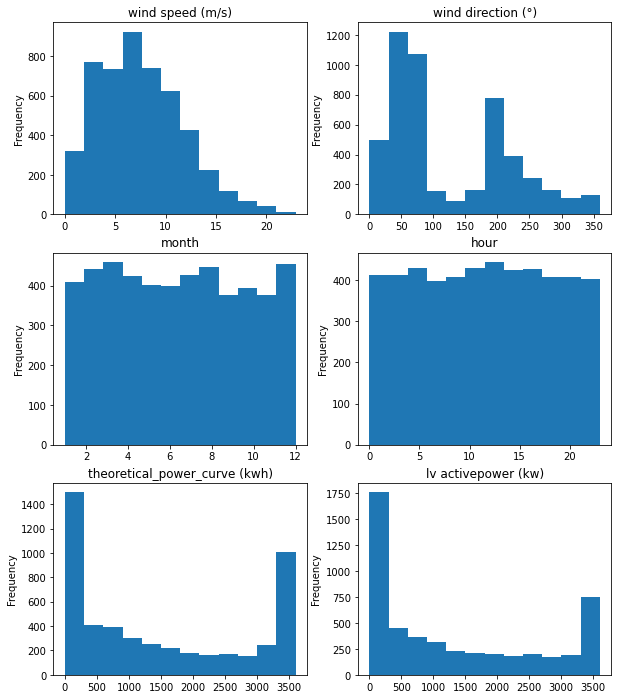

In [ ]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(10,12))
for each in columns:
    plt.subplot(3,2,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1

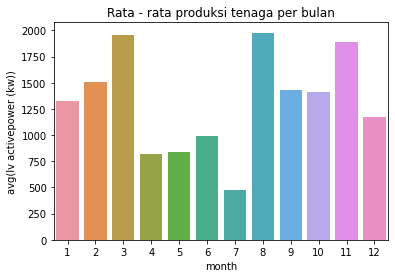

In [ ]:
monthly = df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Rata - rata produksi tenaga per bulan');

,wind speed (m/s),wind direction (°),month,hour,theoretical_power_curve (kwh),lv activepower (kw)
wind speed (m/s),1.000000,-0.082885,-0.008581,0.026955,0.945094,0.911477
wind direction (°),-0.082885,1.000000,-0.183446,0.002234,-0.105932,-0.064545
month,-0.008581,-0.183446,1.000000,-0.010774,-0.001126,0.035498
hour,0.026955,0.002234,-0.010774,1.000000,0.032871,0.031572
theoretical_power_curve (kwh),0.945094,-0.105932,-0.001126,0.032871,1.000000,0.943910
lv activepower (kw),0.911477,-0.064545,0.035498,0.031572,0.943910,1.000000


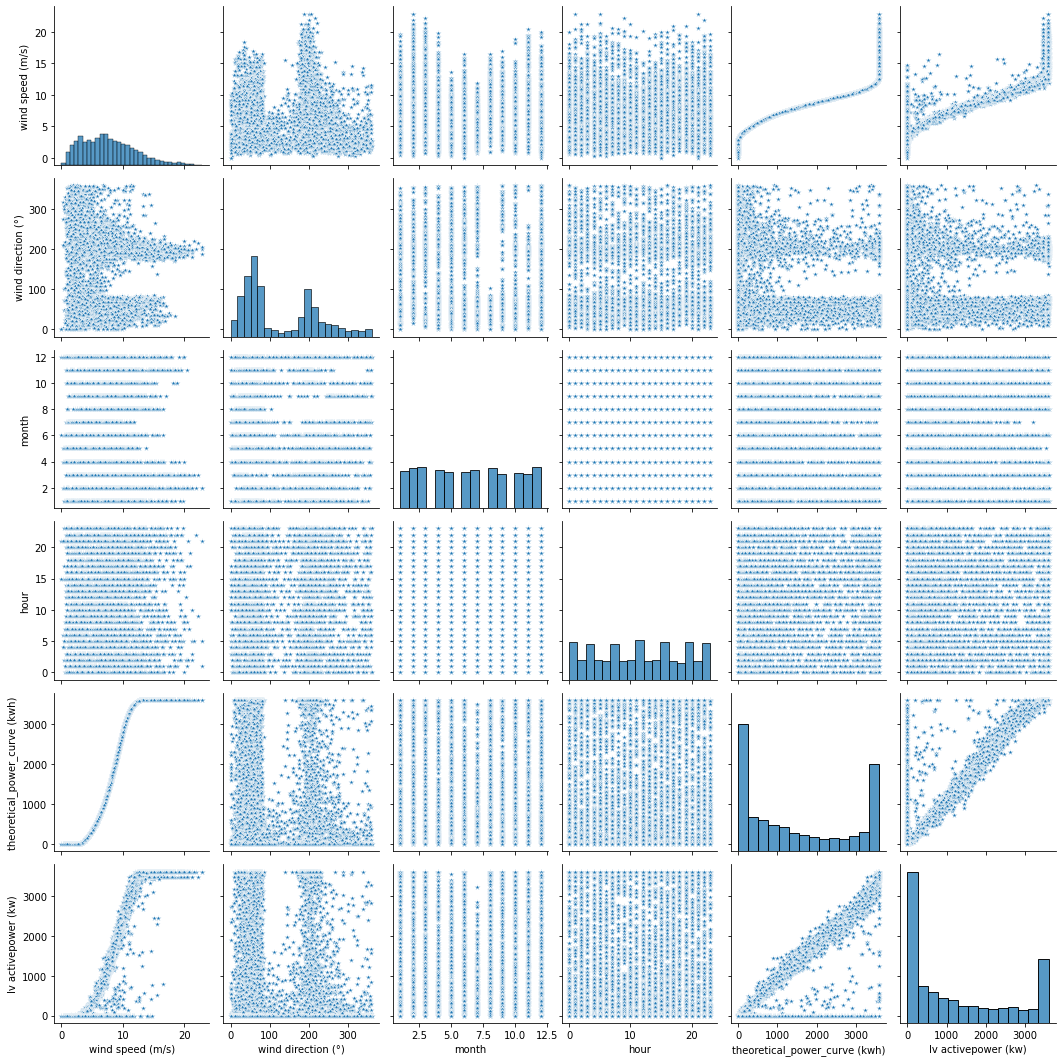

In [ ]:
display(sample_df[columns].corr())
sns.pairplot(sample_df[columns], markers='*');

In [ ]:
df.columns

['date/time',
 'lv activepower (kw)',
 'wind speed (m/s)',
 'theoretical_power_curve (kwh)',
 'wind direction (°)',
 'month',
 'hour']

In [ ]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Convert lv activepower (kw) variabel menjadi label
df = df.withColumn('label', df['lv activepower (kw)'])

# Deklarasi variabel yang akan dipakai
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(df)

# Gabungkan fitur dan label kolom
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



In [ ]:
splits = final_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  35416
Test dataset :  15114


In [ ]:
from pyspark.ml.regression import GBTRegressor

gbm = GBTRegressor(featuresCol='features', labelCol='label')

gbm_model = gbm.fit(train_df)

y_pred = gbm_model.transform(test_df)

y_pred.select('label', 'prediction').show(10)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0| 43.49579596194768|
|             0.0| 55.83733316497577|
|22.8495998382568| 43.49579596194768|
|140.936904907226| 121.3449846755653|
|232.675399780273| 273.2311725924813|
|288.439788818359|287.13256344607674|
|248.946304321289| 273.2311725924813|
|281.934387207031| 273.2311725924813|
|296.469909667968| 326.6580385146483|
|359.028289794921| 326.6580385146483|
+----------------+------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9498813137754829
MAE      :  123.32400824401603
RMSE     :  293.5727885021648
